In [25]:
import os
#os.chdir(os.path.abspath(os.path.join(__file__, os.pardir)))
#os.chdir(os.path.dirname(os.path.realpath(__file__)))
print(os.getcwd())
from __future__ import print_function
from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:100% !important; } .output_svg > div { width: 100% !important; height: 100% !important; }</style>"))
display(HTML("<style>.container { width:100% !important; }</style>"))
import pandas as pd
import matplotlib.pyplot as plt
pd.options.display.mpl_style = 'default'
import corpus, preprocessing, visualize

/mnt/DATA/DEVELOPING/PycharmProjects/recursive-dependency-embedding


In [26]:
import fnmatch, ntpath
#train_data_path = '/media/arne/WIN/Users/Arne/ML/data/corpora/sick/process_sentence3/SICK_CMaggregate'
#train_data_path = '/media/arne/WIN/Users/Arne/ML/data/corpora/ppdb/process_sentence3_ns1/PPDB_CMaggregate'
#train_data_path = '/media/arne/WIN/Users/Arne/ML/data/corpora/sick/process_sentence3/SICK_tt_CMaggregate'
#train_data_path = '/media/arne/WIN/Users/Arne/ML/data/corpora/debate_cluster/process_sentence3/HASAN_CMaggregate'
train_data_path = '/media/arne/WIN/Users/Arne/ML/data/corpora/debate_cluster/process_sentence9/HASAN_CMaggregate'
parent_dir = os.path.abspath(os.path.join(train_data_path, os.pardir))
train_fnames = fnmatch.filter(os.listdir(parent_dir), ntpath.basename(train_data_path) + '.train.*')
train_fnames = [os.path.join(parent_dir, fn) for fn in train_fnames]
test_file_index = 1
test_fname = train_fnames[test_file_index]
del train_fnames[test_file_index] 
print('test file: '+ test_fname)
train_fnames

test file: /media/arne/WIN/Users/Arne/ML/data/corpora/debate_cluster/process_sentence9/HASAN_CMaggregate.train.1


['/media/arne/WIN/Users/Arne/ML/data/corpora/debate_cluster/process_sentence9/HASAN_CMaggregate.train.0']

In [27]:
import corpus
types = corpus.read_types(train_data_path)

In [28]:
import train_fold, similarity_tree_tuple_pb2

def data_iterator(filenames):
    return train_fold.iterate_over_tf_record_protos(
    filenames, similarity_tree_tuple_pb2.SimilarityTreeTuple, multiple_epochs=False)

In [29]:
from itertools import izip
def get_sentence_from_dep_sequence_node(dep_sequence_node):
    arrays = preprocessing.sequence_node_to_arrays(dep_sequence_node)
    texts = visualize.get_text(arrays, types)
    texts_pair = list(izip(*[iter(texts)]*2))
    return [b for (a,b) in texts_pair]

def get_child_ids_from_dep_sequence_node(dep_sequence_node):
    return [child['head'] for child in dep_sequence_node['children']]

In [30]:
#train_iterator = data_iterator(train_fnames[:-1])
train_iterator = data_iterator(train_fnames)
test_iterator = data_iterator([test_fname])

print('load test data ...')
#tuples_test = list(test_iterator)
#print('convert test data ...')
tuples_tokenids_test = [(get_child_ids_from_dep_sequence_node(similarity_tree_tuple['first']), get_child_ids_from_dep_sequence_node(similarity_tree_tuple['second']), similarity_tree_tuple['similarity']) for similarity_tree_tuple in test_iterator]
print(str(len(tuples_tokenids_test)))
print('load train data ...')
#tuples_train = list(train_iterator)
#print('convert train data ...')
tuples_tokenids_train = [(get_child_ids_from_dep_sequence_node(similarity_tree_tuple['first']), get_child_ids_from_dep_sequence_node(similarity_tree_tuple['second']), similarity_tree_tuple['similarity']) for similarity_tree_tuple in train_iterator]
print(str(len(tuples_tokenids_train)))

load test data ...
22503
load train data ...
22503


In [31]:
def ids_to_text(ids):
    return ' '.join([types[i] for i in ids])

print('convert train ids ...')
texts_train = [(ids_to_text(ids1), ids_to_text(ids2), sim) for ids1, ids2, sim in tuples_tokenids_train]
print('convert test ids ...')
texts_test = [(ids_to_text(ids1), ids_to_text(ids2), sim) for ids1, ids2, sim in tuples_tokenids_test]
texts_test[:10]

convert train ids ...
convert test ids ...


[(u"think ' useless talk dictionary definition marriage marriage be base love be important think be difference love people be different sex feeling affection be important UNKNOWN can judge other people love want get marry ' their own right",
  u'abortion be create person reason your ready raise kid put adoption can be good family do murder its wrong have life can have sex should be ready consequence tht come',
  0.0),
 (u'be our right people be nothing constitution gay marriage can do sign ban gay marriage republican blue state veto would have allow gay marriage will let people vote note be fine be ban',
  u'abortion be advise UNKNOWN new life new human live',
  0.0),
 (u'UNKNOWN obama do thing say would do change economy want',
  u"be right wrong agree late time have abortion should be reduce stand week which be age baby can survive think ' dependent situation pregnancy child ' go be bring life poverty abuse be bloody miserable what kind existence be agree child have severe deformity 

In [32]:
import math
def get_idfs(tuples):
    counts = {}
    for t in tuples:
        for tok_id in list(set(t[0])) + list(set(t[1])):
            c = counts.get(tok_id, 0)
            counts[tok_id] = c + 1
    result = {}
    for k in counts:
        result[k] = math.log(len(tuples)*2/counts[k])
    return result

idfs_test = get_idfs(tuples_tokenids_test)
tfidfs_dict = {k:i for i, k in enumerate(sorted(idfs_test))}

def get_tfidf(l, idfs):
    counts = {}
    for t in l:
        c = counts.get(t, 0) + idfs[t] / len(l)
        counts[t] = c
    return counts


tfidfs_test = [(get_tfidf(ids1, idfs_test), get_tfidf(ids2, idfs_test), sim) for ids1, ids2, sim in tuples_tokenids_test]


In [33]:
#from sklearn.feature_extraction import DictVectorizer
import numpy as np
from scipy.stats.stats import pearsonr

def to_vec(v_d, trans):
    result = np.zeros((len(trans),), dtype=float)
    for k in v_d:
        result[trans[k]] = v_d[k]
    return result    

def sim_tfidf(v1, v2):
    return np.dot(v1, v2)/np.linalg.norm(v1)/np.linalg.norm(v2)

tfidf_sim_test = np.array([sim_tfidf(to_vec(tfidf1, tfidfs_dict), to_vec(tfidf2, tfidfs_dict)) for tfidf1, tfidf2, sim in tfidfs_test])
gold_sim_test = np.array([sim for tfidf1, tfidf2, sim in tfidfs_test])
from scipy.stats.stats import pearsonr

# Person's r
print(pearsonr(tfidf_sim_test, gold_sim_test))
# MSE
np.square(tfidf_sim_test - gold_sim_test).mean()

(0.28794784590567984, 0.0)


0.14507716579600416

In [17]:
len_train = [len(ids1) + len(ids2) for ids1, ids2, sim in tuples_tokenids_train]
len_test = [len(ids1) + len(ids2) for ids1, ids2, sim in tuples_tokenids_test]
len_train_single = [len(ids1) for ids1, ids2, sim in tuples_tokenids_train] + [len(ids2) for ids1, ids2, sim in tuples_tokenids_train]
len_test_single = [len(ids1) for ids1, ids2, sim in tuples_tokenids_test] + [len(ids2) for ids1, ids2, sim in tuples_tokenids_test]
len_single = len_train_single + len_test_single
s_len_single = pd.Series(len_single)
s_len_single.describe()

count    89940.000000
mean       129.195430
std        116.252154
min          6.000000
25%         47.000000
50%         90.000000
75%        163.000000
max        700.000000
dtype: float64

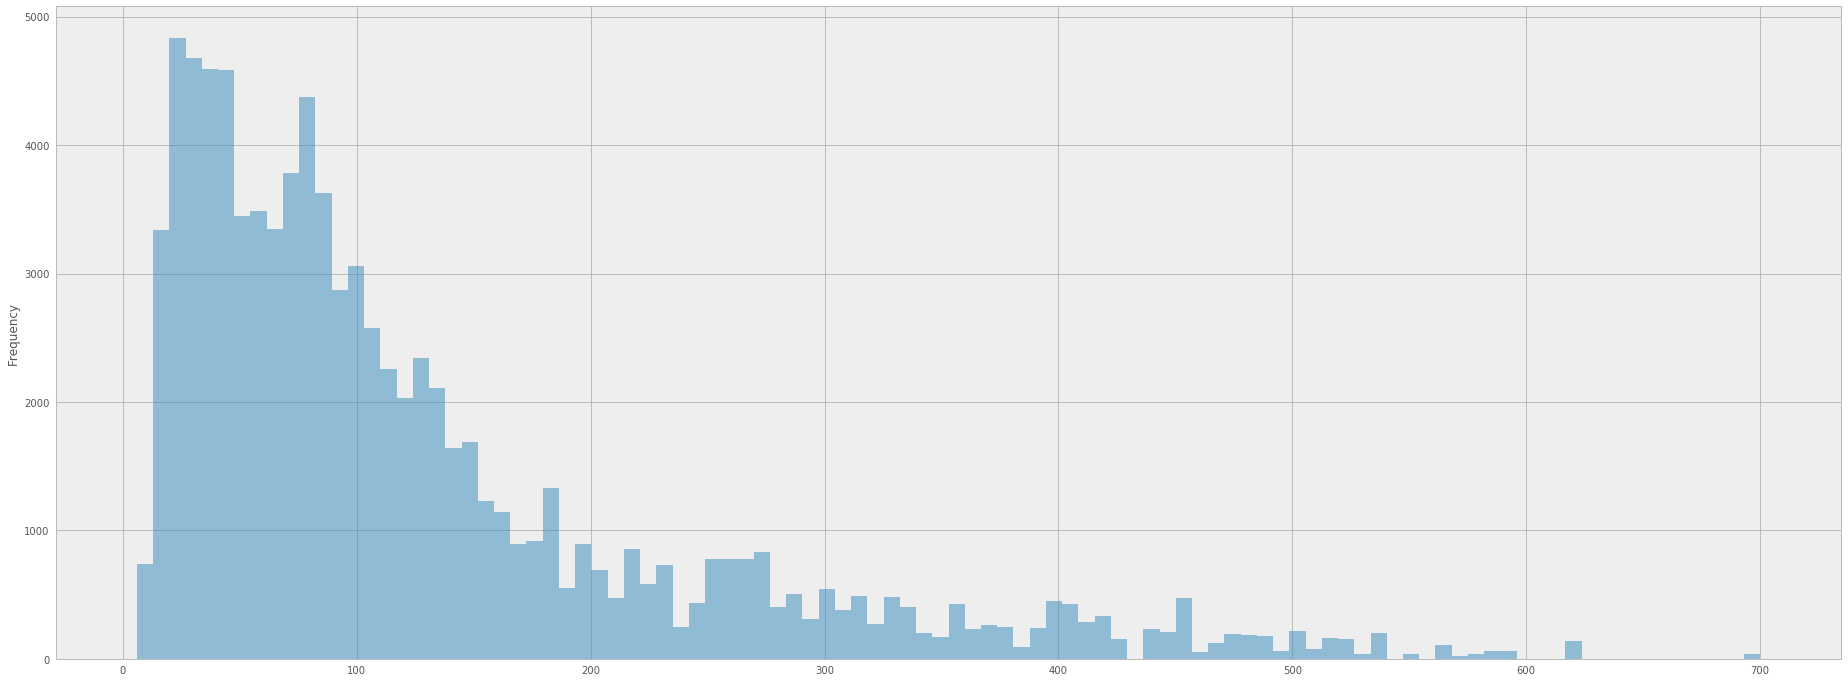

In [19]:
s_len_single.plot(kind='hist', bins=100, figsize=(32, 12), label='train', alpha=0.5)

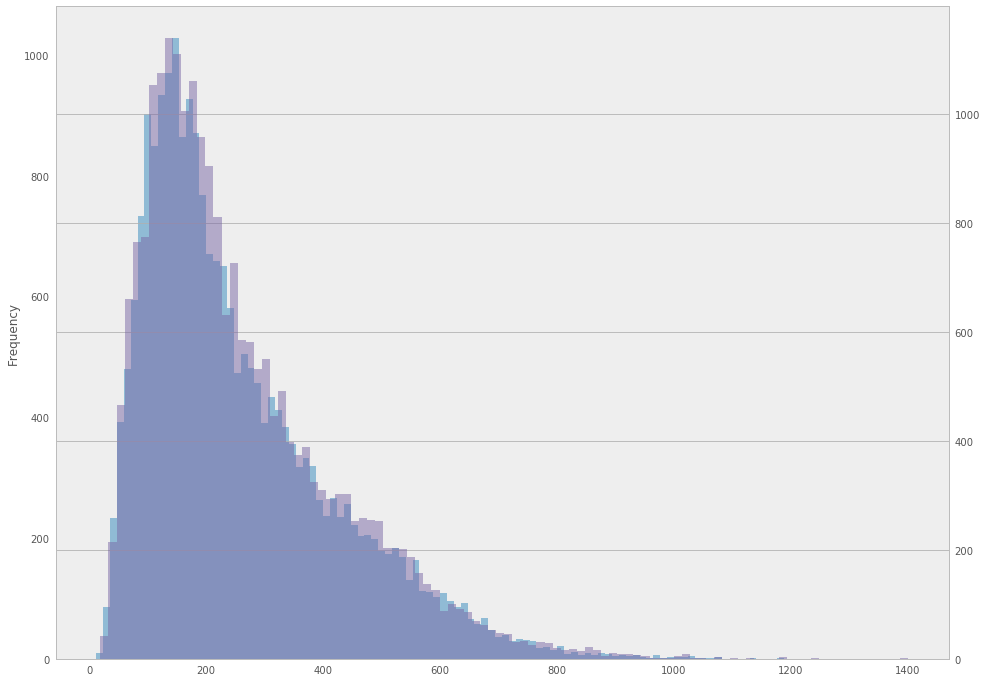

In [21]:
#df_len = pd.DataFrame({'train': pd.Series(len_train), 'test': pd.Series(len_test)})
#df_len.hist(bins=100, figsize=(32, 12))
#f = plt.figure()
s_len_train = pd.Series(len_train)
s_len_test = pd.Series(len_test)
s_len_train.plot(kind='hist', bins=100, figsize=(16, 12), label='train', alpha=0.5)
s_len_test.plot(kind='hist', bins=100, figsize=(16, 12), label='test', alpha=0.5, secondary_y=True)

In [22]:
s_len_train.describe()

count    22485.000000
mean       257.284412
std        164.364773
min         12.000000
25%        135.000000
50%        210.000000
75%        346.000000
max       1188.000000
dtype: float64

In [23]:
s_len_test.describe()

count    22485.000000
mean       259.497309
std        165.480533
min         19.000000
25%        136.000000
50%        213.000000
75%        346.000000
max       1400.000000
dtype: float64

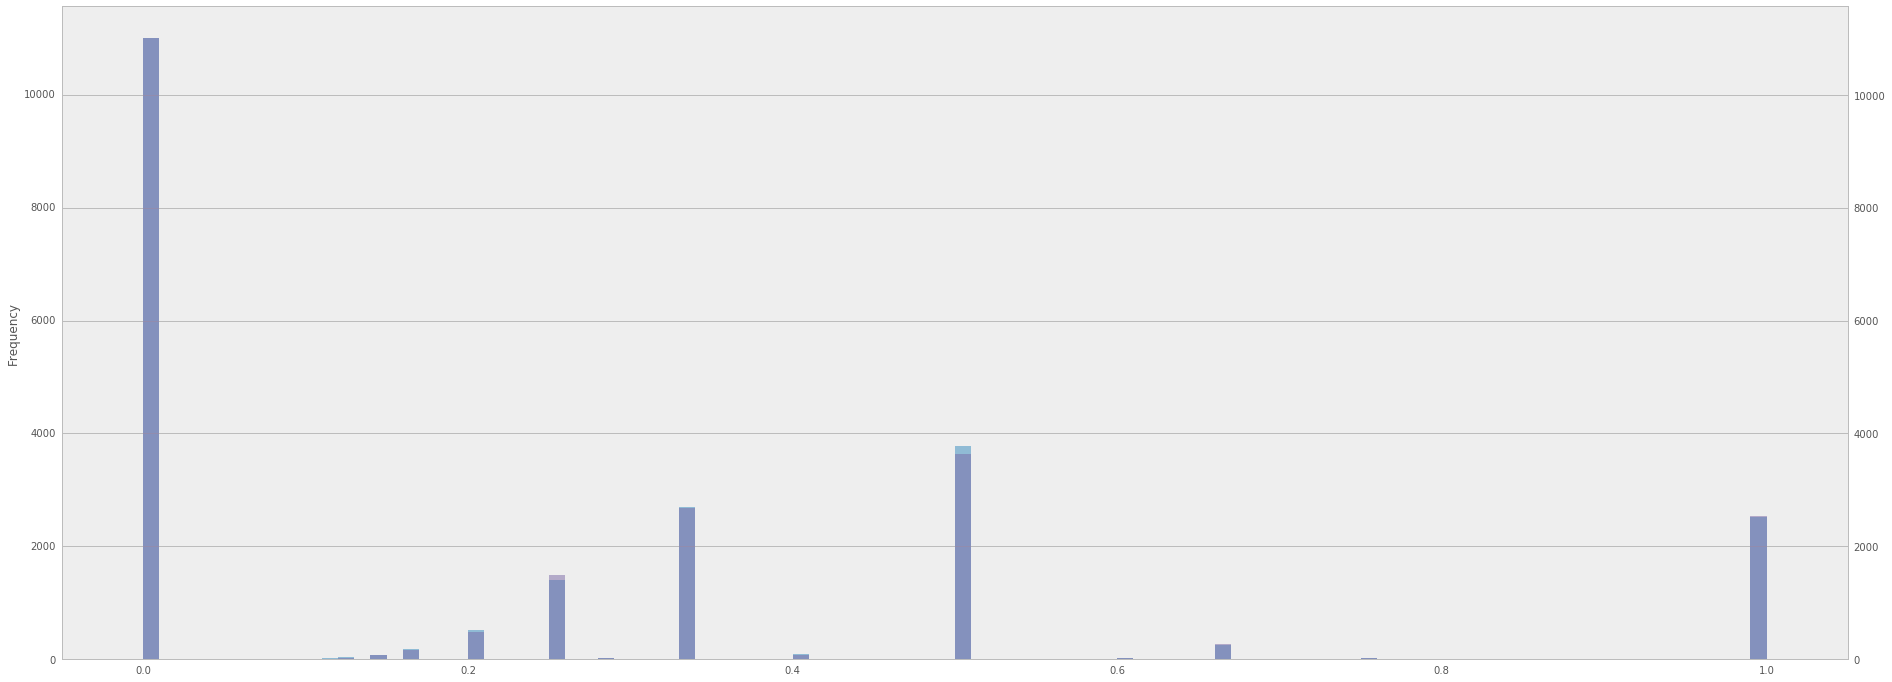

In [24]:
s_sims_train = pd.Series([sim for (_, _, sim) in tuples_tokenids_train])
s_sims_test = pd.Series([sim for (_, _, sim) in tuples_tokenids_test])

s_sims_train.plot(kind='hist',bins=100, figsize=(32, 12), alpha=0.5)
s_sims_test.plot(kind='hist',bins=100, figsize=(32, 12), alpha=0.5, secondary_y=True)

#df_sim = pd.DataFrame({'train': s_sims_train, 'test': s_sims_test})
#df_sim.plot(kind='hist',bins=100, figsize=(16, 12))
#df_sim.hist(bins=100, figsize=(32, 12))

In [26]:
s_sims_train.describe()

count    22485.000000
mean         0.266793
std          0.326937
min          0.000000
25%          0.000000
50%          0.166667
75%          0.500000
max          1.000000
dtype: float64

In [27]:
s_sims_test.describe()

count    22485.000000
mean         0.266504
std          0.327618
min          0.000000
25%          0.000000
50%          0.166667
75%          0.500000
max          1.000000
dtype: float64

In [ ]:
def print_stats(texts_train, texts_test):
    train_sentences_first_unique = set([s1 for (s1, s2, sc) in texts_train])
    train_sentences_second_unique = set([s2 for (s1, s2, sc) in texts_train])
    print('train_sentences_first_unique:\t'+str(len(train_sentences_first_unique)))
    print('train_sentences_second_unique:\t'+str(len(train_sentences_second_unique)))
    train_sentences_unique = train_sentences_first_unique
    train_sentences_unique.update(train_sentences_second_unique)
    print('train_sentences_unique:\t'+str(len(train_sentences_unique)))

    train_tuple = [s1+s2 for (s1, s2, sc) in texts_train]
    print('train_tuple duplicates: '+ str(len(train_tuple) - len(set(train_tuple))))
    print('train_tuple unique: '+ str(len(set(train_tuple))))

    test_sentences_first_unique = set([s1 for (s1, s2, sc) in texts_test])
    test_sentences_second_unique = set([s2 for (s1, s2, sc) in texts_test])
    print('test_sentences_first_unique:\t'+str(len(test_sentences_first_unique)))
    print('test_sentences_second_unique:\t'+str(len(test_sentences_second_unique)))
    test_sentences_unique = test_sentences_first_unique
    test_sentences_unique.update(test_sentences_second_unique)
    print('test_sentences_unique:\t'+str(len(test_sentences_unique)))

    test_tuple = [s1+s2 for (s1, s2, sc) in texts_test]
    print('test_tuple duplicates: '+ str(len(test_tuple) - len(set(test_tuple))))
    print('test_tuple unique: '+ str(len(set(test_tuple))))

    sentences_unique = train_sentences_unique
    sentences_unique.update(test_sentences_unique)
    print('sentences_unique:\t'+str(len(sentences_unique)))
    
    tuple_unique = set(train_tuple)
    tuple_unique.update(set(test_tuple))
    print('tuple unique: '+ str(len(tuple_unique)))
    print('train/test tuple overlap: '+ str(len(set(train_tuple)) + len(set(test_tuple)) - len(tuple_unique)))